1. [Описание проекта](#start)
2. [Предобработка данных](#1step)
3. [Подготовка данных](#2step)
4. [Анализ данных](#3step)
5. [Проверка гипотез](#4step)
6. [Общий вывод](#5step)

# Определение перспективного тарифа для телеком-компании <a id="start"></a> 

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

**Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей
    
**Примечание**: «Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
 
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

**Описание данных**

**Таблица users (информация о пользователях)**:
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

**Таблица calls (информация о звонках)**:
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях)**:
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях)**:
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах)**:
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [31]:
#импортируем библиотеки 
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

In [2]:
#чтение файлов
try:
    calls, internet, messages, tariffs, users = (
    pd.read_csv('calls.csv'),
    pd.read_csv('internet.csv'),
    pd.read_csv('messages.csv'),
    pd.read_csv('tariffs.csv'),
    pd.read_csv('users.csv')
)

except:
    calls, internet, messages, tariffs, users = (
    pd.read_csv('/datasets/calls.csv'),
    pd.read_csv('/datasets/internet.csv'),
    pd.read_csv('/datasets/messages.csv'),
    pd.read_csv('/datasets/tariffs.csv'),
    pd.read_csv('/datasets/users.csv')
)

## Предобработка даннных  <a id="1step"></a>

**Информация о таблицах**

In [3]:
calls.info()
display ('_' * 120)
internet.info()
display ('_' * 120)
messages.info()
display ('_' * 120)
tariffs.info()
display ('_' * 120)
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


'________________________________________________________________________________________________________________________'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


'________________________________________________________________________________________________________________________'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


'________________________________________________________________________________________________________________________'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


'________________________________________________________________________________________________________________________'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Кол-во значений во всех столбцах одинаково всех таблиц одинаково (кроме последнейю. где есть пропуски в столбце churn_date, которые не нужно удалять, т.к. это значит, что тариф действовал на момент выгрузки данных. 

Названия корректны. 

Столбец Unnamed: 0 в таблице internet нумерует строки, его можно удалить. 

Тип данных в столбцах call_date, session_date, message_date, reg_date нужно поменять на соответствующий.

In [4]:
calls['call_date'] = pd.to_datetime(calls['call_date'])
internet['session_date'] = pd.to_datetime(internet['session_date'])
messages['message_date'] = pd.to_datetime(messages['message_date'])
users['reg_date'] = pd.to_datetime(users['reg_date']) #меняем тип данных

internet = internet.drop(columns='Unnamed: 0') #удаляем столбец

Округлим значения в колонках "duration" и "mb_used", так как в "Мегалайн" звонки считаются в минутах

In [5]:
calls['duration'] = np.ceil(calls['duration'])
internet['mb_used'] = np.ceil(internet['mb_used'])

**Проверим данные на дубликаты** 

In [6]:
print('Кол-во дубликатов в таблице calls:', calls.duplicated().sum(),
      '\nКол-во дубликатов в таблице internet:', internet.duplicated().sum(),
      '\nКол-во дубликатов в таблице messages:',  messages.duplicated().sum(),
      '\nКол-во дубликатов в таблице tariffs:', tariffs.duplicated().sum(),
      '\nКол-во дубликатов в таблице users:',  users.duplicated().sum() 
)

Кол-во дубликатов в таблице calls: 0 
Кол-во дубликатов в таблице internet: 0 
Кол-во дубликатов в таблице messages: 0 
Кол-во дубликатов в таблице tariffs: 0 
Кол-во дубликатов в таблице users: 0


Дубликатов в таблицах нет, можно приступать к подготовке данных

## Подготовка данных <a id="2step"></a>

**Посчитаем для каждого пользователя**:

- количество сделанных звонков и израсходованных минут разговора по месяцам

In [7]:
#выделим из даты месяц 
calls['month'] = calls['call_date'].dt.month

In [8]:
cnt_calls = calls.pivot_table(index=['user_id', 'month'], values=['id', 'duration'], aggfunc={'id': 'count', 'duration': 'sum'}).rename(columns={'id':'calls'})
cnt_calls

duration  calls
user_id month                 
1000    5         159.0     22
        6         172.0     43
        7         340.0     47
        8         408.0     52
        9         466.0     58
...                 ...    ...
1498    10        247.0     41
1499    9          70.0      9
        10        449.0     68
        11        612.0     74
        12        492.0     69

[3174 rows x 2 columns]

- количество отправленных сообщений по месяцам

In [9]:
#выделим из даты месяц 
messages['month'] = messages['message_date'].dt.month

In [10]:
cnt_message = messages.pivot_table(index=['user_id', 'month'], values='id', aggfunc='count').rename(columns={'id':'messages'})
cnt_message.reset_index()

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


- объем израсходованного интернет-трафика по месяцам

In [11]:
#выделим из даты месяц 
internet['month'] = internet['session_date'].dt.month


In [12]:
cnt_internet = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
cnt_internet.reset_index()

,user_id,month,mb_used
0,1000,5,2256.0
1,1000,6,23257.0
2,1000,7,14016.0
3,1000,8,14070.0
4,1000,9,14581.0
...,...,...,...
3198,1498,10,20604.0
3199,1499,9,1848.0
3200,1499,10,17809.0
3201,1499,11,17984.0


- помесячную выручку с каждого пользователя 

In [13]:
notgen = cnt_calls.merge(cnt_message, on=['user_id', 'month'], how='outer') #объединяем таблицы
general = notgen.merge(cnt_internet, on=['user_id', 'month'], how='outer')
general.reset_index(inplace=True)

In [14]:
general = general.merge(users[['user_id','tariff']], on='user_id', how='left') #присоединим столбец с тарифами

Так как при объединии таблиц в некотрых столбцах возникают пропуски, заполним их нулями

In [15]:
general = general.fillna(0)
general

,user_id,month,duration,calls,messages,mb_used,tariff
0,1000,5,159.0,22.0,22.0,2256.0,ultra
1,1000,6,172.0,43.0,60.0,23257.0,ultra
2,1000,7,340.0,47.0,75.0,14016.0,ultra
3,1000,8,408.0,52.0,81.0,14070.0,ultra
4,1000,9,466.0,58.0,57.0,14581.0,ultra
...,...,...,...,...,...,...,...
3209,1489,9,0.0,0.0,32.0,17232.0,smart
3210,1489,10,0.0,0.0,21.0,19588.0,smart
3211,1489,11,0.0,0.0,20.0,17516.0,smart
3212,1489,12,0.0,0.0,35.0,17341.0,smart


In [16]:
#зададим функцию для расчета выручки

def rev(df):                                                   
    if df['tariff'] == 'smart':
        minutes = df['duration'] - tariffs['minutes_included'][0]
        mesg = df['messages'] - tariffs['messages_included'][0]
        mb = df['mb_used'] - tariffs['mb_per_month_included'][0]
        
        if minutes < 0:
            minutes = 0
        if mesg < 0:
            mesg = 0
        if mb < 0:
            mb = 0
    
        res = minutes * tariffs['rub_per_minute'][0] + mesg * tariffs['rub_per_message'][0] + mb/1024 * tariffs['rub_per_gb'][0] + tariffs['rub_monthly_fee'][0]
        return res
    else:
        minutes = df['duration'] - tariffs['minutes_included'][1]
        mesg = df['messages'] - tariffs['messages_included'][1]
        mb = df['mb_used'] - tariffs['mb_per_month_included'][1]
        
        if minutes < 0:
            minutes = 0
        if mesg < 0:
            mesg = 0
        if mb < 0:
            mb = 0
    
        res = minutes * tariffs['rub_per_minute'][1] + mesg * tariffs['rub_per_message'][1] + mb/1024 * tariffs['rub_per_gb'][1] + tariffs['rub_monthly_fee'][1]
        return res
   

In [17]:
general['revenue'] = general.apply(rev, axis=1)
general['mb_used'] = general['mb_used'] / 1024
general['mb_used'] = np.ceil(general['mb_used'])
general = general.rename(columns={'mb_used':'gb_used'})
general.sort_values(by='revenue', ascending=False).head(5)

,user_id,month,duration,calls,messages,gb_used,tariff,revenue
3106,1486,12,1007.0,133.0,83.0,38.0,smart,6711.015625
1622,1261,12,1074.0,141.0,22.0,32.0,smart,5658.132812
260,1042,12,728.0,121.0,75.0,37.0,smart,5578.335938
3105,1486,11,764.0,108.0,96.0,36.0,smart,5573.554688
1793,1286,12,739.0,95.0,68.0,35.0,smart,5186.429688


## Анализ данных <a id="3step"></a>

Расчитаем, сколько в среднем нужно пользователям каждого тарифа звонком, сообщения и интернет-трафика в месяц

In [18]:
mean_gen = general.pivot_table(index=['tariff','user_id'], values=['duration', 'messages', 'gb_used'], aggfunc='median')

mean_gen

duration  gb_used  messages
tariff user_id                             
smart  1001        422.0     16.5       0.0
       1002        214.0     18.0      11.0
       1005        593.5      8.0      49.0
       1006        356.0     16.0       0.0
       1007        480.0     15.0      26.0
...                  ...      ...       ...
ultra  1476        492.0     16.0       5.0
       1485        584.0     23.0     155.0
       1491        531.0     18.0      52.0
       1493        372.0     27.0      47.0
       1495        954.0     29.0      82.0

[498 rows x 3 columns]

Расчитаем стандартное отклонение и дисперсию по тарифам

In [19]:
stdvar = mean_gen.pivot_table(index='tariff', values=['duration','messages','gb_used'], aggfunc= ['mean', 'var','std'])

stdvar

mean                                 var             \
          duration    gb_used   messages      duration    gb_used   
tariff                                                              
smart   437.468571  16.965714  33.770000  25685.390127  16.639222   
ultra   557.503378  20.334459  56.983108  92290.576519  75.732614   

                            std                       
           messages    duration   gb_used   messages  
tariff                                                
smart    784.596662  160.266622  4.079120  28.010653  
ultra   2424.263318  303.793641  8.702449  49.236809

Построим графики распределения

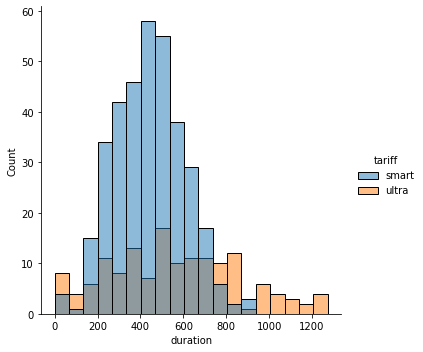

In [20]:
sns.displot(x='duration',
            hue='tariff',
            data=mean_gen)

Судя по графику, пользователи тарифа "Ультра" не выговаривают включенные в их тариф 3000 минут и в целом наблюдается больший разброс по использованным минутам; У пользователей "Смарт" кол-во использованных минут в основном находится в промежутке от 200 до 600. Также можно сказать, что большая часть пользователей этого тарифа использует больше включенных 500 минут, а следовательно, переплачивает.

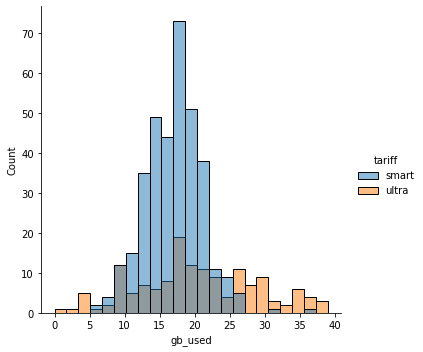

In [21]:
sns.displot(x='gb_used',
            hue='tariff',
            data=mean_gen)

По использованию интернет-трафика ситуация аналогичная. Кол-во используемых мб интернета у пользователей "Смарт" сосредоточено в меньшем диапазоне, чем у пользователей тарифа "Ультра". Пользователи тарифа "Смарт" так же часто не укладываются в предусмотренные 15 ГБ

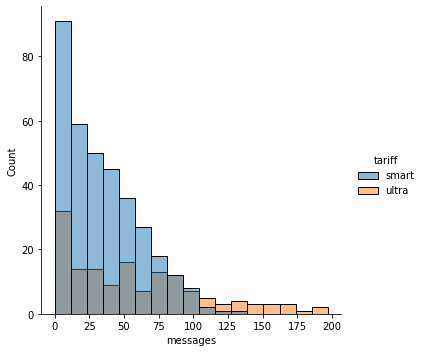

In [22]:
sns.displot(x='messages',
            hue='tariff',
            data=mean_gen)

Здесь тоже значения пользователей тарифа "Ультра" более разнообразны, не превышают предусмотренного тарифом максимума. 

## Проверка гипотез <a id="4step"></a>

H₀ = средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются.

H₁ = средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

In [23]:
ultra = general.loc[general['tariff'] == 'ultra', 'revenue']
smart = general.loc[general['tariff'] == 'smart', 'revenue']

alpha = .001

results = st.ttest_ind(
    ultra, 
    smart,
    equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 8.931402711368788e-296
Отвергаем нулевую гипотезу


По результатам теста мы отвергаем гипотезу о равенстве средней выручки двух тарифов. Это можно проверить, посчитав среднуюю выручку по тарифам в нашей выборке: 

In [24]:
general.groupby('tariff').agg({'revenue':'median'})

,revenue
tariff,
smart,959.898438
ultra,1950.000000


Действительно, средняя выручка пользователей тарифа "Ультра" больше, чем по тарифу "Смарт" почти в 2 раза

H₀ = средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов..

H₁ = средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [25]:
general = general.merge(users[['user_id', 'city']], on='user_id', how='left')
general

,user_id,month,duration,calls,messages,gb_used,tariff,revenue,city
0,1000,5,159.0,22.0,22.0,3.0,ultra,1950.000000,Краснодар
1,1000,6,172.0,43.0,60.0,23.0,ultra,1950.000000,Краснодар
2,1000,7,340.0,47.0,75.0,14.0,ultra,1950.000000,Краснодар
3,1000,8,408.0,52.0,81.0,14.0,ultra,1950.000000,Краснодар
4,1000,9,466.0,58.0,57.0,15.0,ultra,1950.000000,Краснодар
...,...,...,...,...,...,...,...,...,...
3209,1489,9,0.0,0.0,32.0,17.0,smart,915.625000,Санкт-Петербург
3210,1489,10,0.0,0.0,21.0,20.0,smart,1375.781250,Санкт-Петербург
3211,1489,11,0.0,0.0,20.0,18.0,smart,971.093750,Санкт-Петербург
3212,1489,12,0.0,0.0,35.0,17.0,smart,936.914062,Санкт-Петербург


In [26]:
msk = general.loc[general['city'] == 'Москва', 'revenue']
not_msk = general.loc[general['city'] != 'Москва', 'revenue']

alpha = .001

results = st.ttest_ind(
    msk, 
    not_msk,
    equal_var = False)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 


p-значение: 0.4549775646471024
Не получилось отвергнуть нулевую гипотезу


Чтобы убедиться в результатах теста посмотрим среднуюю вырочку в Москве и регионах

In [27]:
def reg(df):
    if df['city'] == 'Москва':
        return 'Москва'
    else:
        return 'Регионы'

In [28]:
general['regions'] = general.apply(reg, axis=1)
general.groupby('regions').agg({'revenue':'mean'})

,revenue
regions,
Москва,1507.276762
Регионы,1482.063727


Выручка пользователей из Москвы незначительно превышает выручку пользователей из других регионов, но различие небольшое

*Дополнительно я решила посмотреть, сколько в среднем переплачивают пользователи тарифа*

In [32]:
smrt = general.query('tariff == "smart" & revenue > 550')
smrt['overpayment'] = smrt['revenue'] - 550
smrt

smrt['overpayment'].mean()

914.8264029654655

In [33]:
ult = general.query('tariff == "ultra" & revenue > 1950')
ult['overpayment'] = ult['revenue'] - 1950
ult

ult['overpayment'].mean()

812.4777722714553

*Пользователи тарифа "Смарт" переплачивают немного больше пользователей тарифа "Ультра", но даже с такой переплатой итоговая сумма выходит меньше стоимости 2ого тарифа*

## Общий вывод <a id="5step"></a>

В ходе проведенного исследования мы проверили 2 гипотезы, в результате чего выяснили:
- средняя выручка с пользователей из Москвы и других регионов не отличается;
- средняя выручка с пользователей тарифов "Ультра" превышает среднюю выручку с пользователей тарифа "Смарт" практически в 2 раза: 1950 рублей и 959 рублей.

Так же мы выяснили, что поведение пользователей более тарифа "Ультра" более разнообразно, что связано с большим объемом включенных в тариф услуг, позволяющего не ограничивать себя. 
Значения полученных услуг пользователями тарифа "Смарт" в основном лежат в ограниченном диапазоне. Также эти пользователи наиболее часто переплачивают за все предоставляемые услуги (минуты, сообщения, интрнет-трафик). У пользователей тарифа "Ультра" переплаты связаны только с интернет-трафиком.

Таким образом, можно сказать, что лучшим тарифом, как для компании с точки зрения прибыльности, так и для клиентов, можно назвать тариф "Ультра".